In [12]:
import json
import os
import random

import cv2
from datasets import load_from_disk
import evaluate
from matplotlib import pyplot as plt
import numpy as np
import torch
from transformers import VisionEncoderDecoderModel, AutoImageProcessor, AutoTokenizer

In [2]:
image_processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [3]:
image_processor = AutoImageProcessor.from_pretrained("training/checkpoint-19080")
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = VisionEncoderDecoderModel.from_pretrained("training/checkpoint-19080")

In [4]:
dataset = load_from_disk("dataset/preprocessed")
dataset.set_format(type="numpy")
data_train = dataset["train"]
data_train

Dataset({
    features: ['pixel_values', 'labels'],
    num_rows: 22895
})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: a man was playing some musical instrument on the center of road many people walking by his side and some sit on the chairs with table under the hut  and have their food
Model Ouput: A man is playing a musical instrument in front of a crowd of people, while people are walking by.


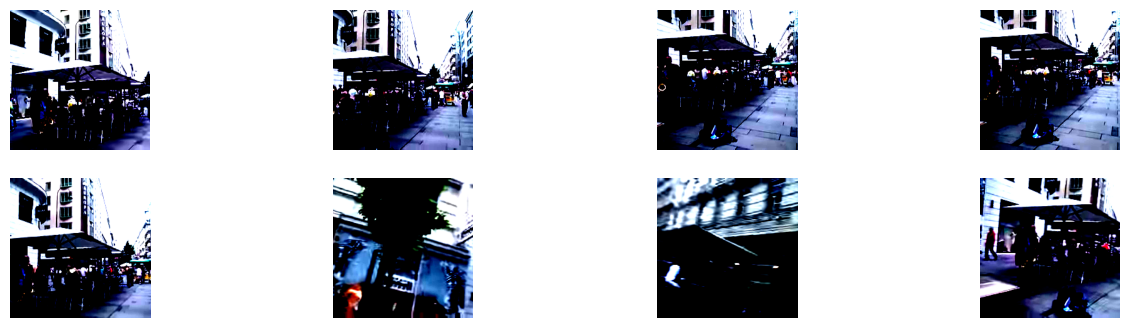

In [15]:
# visualize training data and model output

idx = random.randint(0, len(data_train) - 1)
data = data_train[idx]
frames = data["pixel_values"]
caption = data["labels"]

caption = tokenizer.decode(caption, skip_special_tokens=True)
print("Label: %s" % caption)

FRAMES_PER_VIDEO = 8
rows = 2
cols = FRAMES_PER_VIDEO // rows
fig = plt.figure(figsize=(16, 4))

for i in range(FRAMES_PER_VIDEO):
    frame = frames[i]
    frame = np.moveaxis(frame, 0, 2)
    
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(frame)
    plt.axis("off")
    
generated_ids = model.generate(torch.from_numpy(frames).unsqueeze(0), max_length=30, num_beams=2, early_stopping=True)
generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
print("Model Ouput: %s" % generated_text)

Video ID: W1Yjfexk8l8_000444_000454

Captions:
['A man eats something and then drinks some wine in his home.', 'A man moved around his tongue in his mouth and then drank wine', 'A man chews something in his mouth before taking a sip of wine.', 'A man tastes some food before taking a taste of red wine.', 'A guy sitting down and trying a glass of wine at what seems to be his house.', 'A man chews and then takes a small sip of red wine.', 'A man is sitting and swishing wine around in his mouth, then takes a sip of wine.', 'A man takes a big sip of red wine from a wine glass.', 'A man says he will try some wine and then proceeds to do it.', 'A man is sitting by himself while he tastes some red wine out of a glass.']

Longest Caption:
A guy sitting down and trying a glass of wine at what seems to be his house.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


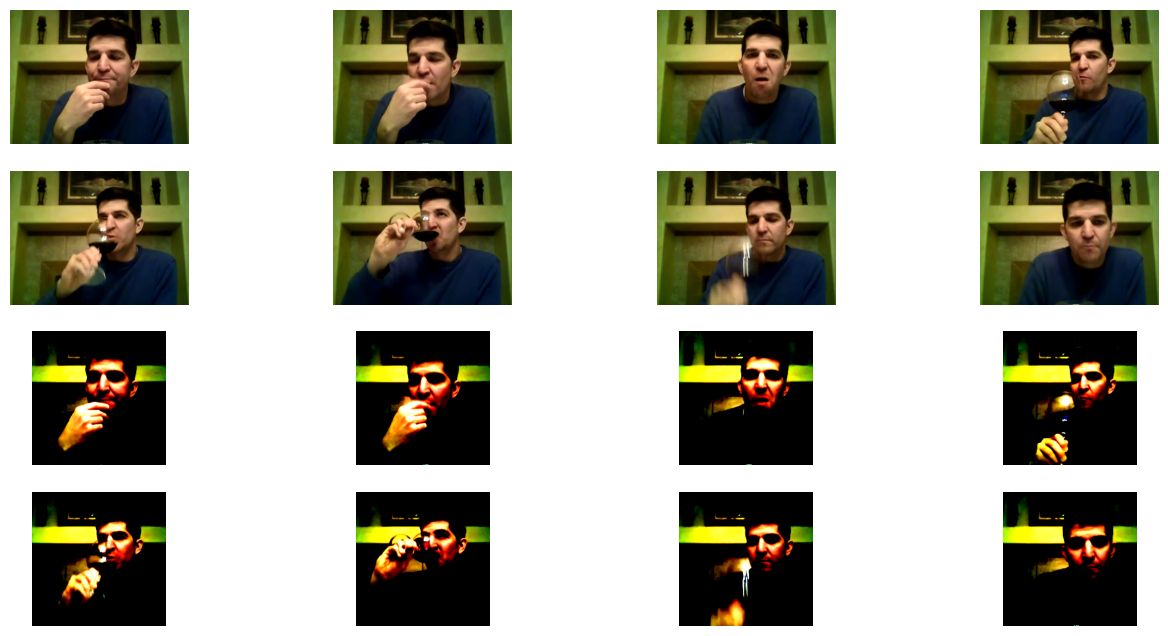

In [20]:
# visualize video frame sampling and image processing

FRAMES_PER_VIDEO = 8
rows = 4
cols = 4
fig = plt.figure(figsize=(16, 8))

with open("dataset/vatex_train_captions.json") as file:
    data = json.load(file)
    idx = random.randint(0, len(data) - 1)
    item = data[idx]
    
    video_id = item["videoID"]
    captions = item["enCap"]
    
    print("Video ID: %s" % video_id)
    print("\nCaptions:")
    print(captions)
    
    # longest caption
    max_len = -np.inf
    max_cap = None
    for caption in captions:
        length = len(caption.split(" "))
        if length > max_len:
            max_len = length
            max_cap = caption
    print("\nLongest Caption:")
    print(max_cap)
    
    videos_path = "dataset/videos"
    video_path = os.path.join(videos_path, "%s.mp4" % video_id)
    if not os.path.isfile(video_path):
        video_path = os.path.join(videos_path, "%s.webm" % video_id)
    video = cv2.VideoCapture(video_path)
        
    # count number of frames
    frame_count = 0
    while True:
        ret = video.grab()
        if not ret:
            break
        frame_count += 1
    video.set(cv2.CAP_PROP_POS_FRAMES, 0)
        
    # fixed frame sampling
    indices = np.linspace(0, frame_count, num=FRAMES_PER_VIDEO, endpoint=False).astype(np.int64)
    # random frame sampling
    #indices = np.sort(np.random.uniform(low=0, high=frame_count, size=self.num_frames).astype(np.int64))
    
    # get frames
    frames = []
    frame_count, frame_idx = 0, 0
    while frame_idx < len(indices):
        if frame_count == indices[frame_idx]:
            _, frame = video.read()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
            frame_idx += 1
            
            fig.add_subplot(rows, cols, frame_idx)
            plt.imshow(frame)
            plt.axis("off")
        else:
            video.grab()
        frame_count += 1
    video.release()
    
    # processed frames
    pixel_values = image_processor(frames, return_tensors="np").pixel_values[0]
    pixel_values = np.moveaxis(pixel_values, 1, 3)
    for i, frame in enumerate(pixel_values):
        fig.add_subplot(rows, cols, i + 8 + 1)
        plt.imshow(frame)
        plt.axis("off")

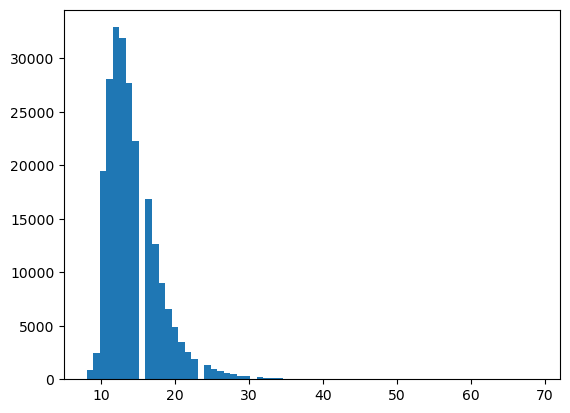

Mean:
[14.23141759 14.22067429 14.1939034  14.24962879 14.24181151 14.2024631
 14.21862171 14.23556643 14.19761551 14.23595947]
Min:
[8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
Max:
[65. 55. 52. 51. 51. 64. 69. 59. 53. 52.]


In [23]:
# visualize caption length distribution

with open("dataset/vatex_train_captions.json") as file:
    lengths = []
    means = np.zeros(10)
    mins = np.ones(10) * np.inf
    maxs = np.zeros(10)
    
    data = json.load(file)
    for video in data:
        for i, caption in enumerate(video["enCap"]):
            length = len(caption.split(" "))
            lengths.append(length)
            means[i] += length
            mins[i] = min(mins[i], length)
            maxs[i] = max(maxs[i], length)
    
    plt.hist(lengths, bins=int(maxs.max()))
    plt.show()
    
    means /= len(data)
    print("Mean:")
    print(means)
    print("Min:")
    print(mins)
    print("Max:")
    print(maxs)

In [ ]:
metric = evaluate.load("rouge")
def metrics(eval_preds):
    preds, labels = eval_preds
    preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    return metric.compute(predictions=preds, references=labels)

In [16]:
metric = evaluate.load("rouge")
rouge = np.zeros(4)
count = 0

with open("dataset/vatex_train_captions.json") as file:
    json_data = json.load(file)
    idx = random.randint(0, len(json_data) - 1)
    data = json_data[idx]
    
    captions = data["enCap"]
    print(captions)
    for i, cap1 in enumerate(captions):
        for j in range(i + 1, len(captions)):
            cap2 = captions[j]
            result = metric.compute(predictions=[cap1], references=[cap2])
            rouge += np.fromiter(result.values(), dtype=float)
            count += 1

print(rouge / count)

['A person is holding a rubrics cube and turning it.', 'Some one is spelling three letter words while turning a rubicks cube.', 'A boy spins a rubix cube around while explaining what he is doing.', "Someone manipulates a Rubic's cube while stating a series of letters.", "A person shows how to solve a Rubix cube using a the F, R, U, F', U', R' system.", 'A young man manipulates a rubix cube while reciting letters.', "A teenage boy demonstrates how to apply the caller and Rubik's cube.", 'A person is talking and trying to solve the Rubik cube.', 'A boy is demonstrating how to solve a rubix cube.', 'a person interacts with a cube that they have and try to figure it out']
[0.31179975 0.05699192 0.26847855 0.26847855]
